<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# MSDS 7331
# Clustering

###  Glenn Oswald & Ian Kinskey

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# Introduction

## Task

In this notebobok, we pursue a single classification task:  predict whether the level of police incidents (per 25,000 residents) is high or low for a given postal code and date.  We determine the high/low threshold to use in the course of our analysis.

!!!! The AdaBoost estimator is used with a hyperparameter configuration deemed optimal as part of our laboratory 2 analysis.

We utilize multiple clustering algorithms in order to engineer features to aid us in our classification task.

## Scenario

In September of 2015, the Austin Police Department(APD) has asked us to predict the level of incidents by postal code in Austin for the final 3 months of the year.  The APD will use this information to improve alocating their police officers throughout the city.  

We are also provided highly accurate forecasts for daily weather measurements (precipitation and temperature), key economic indicators, and population estimates.

Under the constraints of this scenario, we will use the first 57 months of the the data (January 2011 through September 2015) for training and testing models.  We will then validate those models against the final three months of data (October 2015 through December 2015).  This partitioning of the data can be visualized as follows:
![](img/lab-2-train-test-validate-split.png)

---
## Evaluation Metrics

### Classification 
As with most classifiers, accuracy is our ultimate objective.  However, due to imbalanced classes, we must take precautions to ensure our classifiers are not incentivized to overpredict for the majority class.  The class imbalance of approximately 75% of daily incidents below the threshold and 25% above the threshold is depicted in the plot below.  The absolute level of incidents with a threshold of 21 as our binary response.  Later in this notebook, we re-examine the class imbalance of our binary response. 

![](img/class-imbalance.png)  

We use as our scorer the geometric mean of accuracy and true positive rate—refered to as the “composite score”—given by the following formulas:

$$accuracy = \frac{true \ positives + true \ negatives}{count \ of \ all \ predictions}$$  
$$true \ positive \ rate = \frac{true \ positives}{true \ positives + false \ negatives}$$  
$$composite \ score = \sqrt{(1 + accuracy)(1 + true \ positive \ rate)} - 1$$

In [1]:
import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix

def score_func(y, y_pred, **kwargs):
    acc = np.float64(accuracy_score(y, y_pred)) # accuracy
    cm = confusion_matrix(y, y_pred) # confusion matrix
    tp = np.float64(cm[1][1]) # true positives
    fn = np.float64(cm[1][0]) # false negatives
    tpr = tp / (tp + fn)      # true positive rate
    comp_score = np.sqrt((1+acc)*(1+tpr)) - 1 # calculate composite score
    return comp_score

comp_scorer = make_scorer(score_func=score_func, greater_is_better=True)

### Clustering

As we will be utilizing clustering techniques to engineer features in service of our classification goal, we will use the composite score of our classifier as the evaluation metric for our clustering models.

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# Data Preparation

---

## Import Data

Next, we create a dictionary containing the names and data types of the columns of the data we will use for our analysis.

In [3]:
df_types = {'incident_rep_no':np.int64
            ,'crime_type':object
            ,'address':object
            ,'latitude':np.float64
            ,'longitude':np.float64
            ,'consumer_price_index_tx':np.float64
            ,'nonfarm_employment_tx':np.float64
            ,'unemployment_tx':np.float64
            ,'single_family_building_permits_tx':np.int64
            ,'multi_family_building_permits_tx':np.int64
            ,'existing_single_family_home_sales_tx':np.int64
            ,'existing_single_family_home_price_tx':np.int64
            ,'non_residential_building_construction':np.float64
            ,'total_sales_tax_collections_retail_tx':np.float64
            ,'total_sales_tax_collections_tx':np.float64
            ,'retail_gasoline_price_tx':np.float64
            ,'retail_diesel_price_tx':np.float64
            ,'precipitation_inches':np.float64
            ,'mean_temp_f':np.float64
            ,'route_short_name':object
            ,'neighborhood_short_name':object
            ,'postal_code_short_name':object
            ,'locality_short_name':object
            ,'estimate_total_population':np.float64
            ,'date':object,'day_of_month':np.int64
            ,'month':np.int64
            ,'year':np.int64
            ,'dow':np.int64
            ,'hour':np.int64
            ,'minute':np.int64
            ,'crime_group':object
            ,'crime_subgroup':object
            ,'violent':np.int64
            ,'sexual':np.int64
            ,'postal_code':object
            ,'square_miles':np.float64
            ,'square_feet':np.float64}

Set the data path.

In [4]:
from pathlib import Path

rel_path = Path('data/processed/apd-incidents-consolidated-proc-v2.txt')
data_path = Path.cwd() / rel_path

In [5]:
df = pd.read_csv(data_path
                ,sep=";"
                ,encoding='utf-8'
                ,dtype=df_types
                ,parse_dates=['date'])

In [6]:
df.head()

,incident_rep_no,crime_type,address,latitude,longitude,consumer_price_index_tx,nonfarm_employment_tx,unemployment_tx,single_family_building_permits_tx,multi_family_building_permits_tx,...,dow,hour,minute,crime_group,crime_subgroup,violent,sexual,postal_code,square_miles,square_feet
0,20114,CRED CARD ABUSE - OTHER,6917 CARWILL DR,30.301461,-97.644466,203.057,10.5293,7.8,6355,2044,...,1,12,25,PROPERTY,THEFT/BURGLARY,0,0,78724,24.395,680093568.0
1,2011801773,POSS/PROMO CHILD PORNOGRAPHY,3404 S US 183 HWY SB,30.200220,-97.684349,203.057,10.5293,7.8,6355,2044,...,1,19,9,PERSONAL,PUBLIC_NUISANCE,0,1,78744,21.398,596542003.2
2,2011802131,THEFT,9905 N LAMAR BLVD,30.368549,-97.693075,203.057,10.5293,7.8,6355,2044,...,1,0,29,PROPERTY,THEFT/BURGLARY,0,0,78753,10.967,305742412.8
3,2011802239,AGG ASLT STRANGLE/SUFFOCATE,7211 EASY WIND DR,30.340454,-97.718838,203.057,10.5293,7.8,6355,2044,...,1,23,3,PERSONAL,ASSAULT,1,0,78752,3.343,93197491.2
4,2011802274,FAMILY DISTURBANCE,1435 MANFORD HILL DR,30.358825,-97.671299,203.057,10.5293,7.8,6355,2044,...,1,23,24,PERSONAL,THREATS_AND_HARASSMENT,0,0,78753,10.967,305742412.8


---

## Drop Features

Next, we drop variables that we no longer need, either because they are irrelevant to our analysis, no longer necessary after the creation of new variables, or might contain information about the response and thus might leak the "answer into the question."

In [7]:
df.drop(['incident_rep_no' # unique identifer of rows not needed for this analysis
              ,'crime_type' # irrelevant to this analysis (too granular)
              ,'address' # irrelevant to this analysis (too granular)
              ,'latitude' # irrelevant to this analysis (too granular)
              ,'longitude' # irrelevant to this analysis (too granular)
              ,'route_short_name' # irrelevant to this analysis (too granular)
              ,'neighborhood_short_name' # irrelevant to this analysis (too granular)
              ,'locality_short_name' # all incidents occur in Austin, rendering this column useless
              ,'crime_group' # not of interest here (too granular i.e. incident specific)
              ,'crime_subgroup' # not of interest here (too granular i.e. incident specific)
              ,'sexual' # not of interest here (too granular i.e. incident specific)
              ,'violent' # not of interest here (too granular i.e. incident specific)
              ,'date' # redundant w.r.t. day, month, and year cols
              ,'hour' # too granular (aggregation is to the day level)
              ,'minute' # too granular (aggregation is to the day level)
              ,'square_miles'] # redundant with square feet
              ,axis=1
              ,inplace=True)

---

## Create Features & Response

Population size (or variables which may encoded information about population size) is an important variable. For this analysis, we will calculate the estimate population _per 100,000 square feet_.  This unit of size was chosen as it approximates the typical area of one city block. 

In [8]:
df['population_per_100ksqft'] = df['estimate_total_population'] / df['square_feet'] * 100000.0

Next, we group our data such that each row will correspond to a single day and postal code.

In [9]:
# group by columns
grp_cols = ['consumer_price_index_tx'
            ,'nonfarm_employment_tx'
            ,'unemployment_tx'
            ,'single_family_building_permits_tx'
            ,'multi_family_building_permits_tx'
            ,'existing_single_family_home_sales_tx'
            ,'existing_single_family_home_price_tx'
            ,'non_residential_building_construction'
            ,'total_sales_tax_collections_retail_tx'
            ,'total_sales_tax_collections_tx'
            ,'retail_gasoline_price_tx'
            ,'retail_diesel_price_tx'
            ,'precipitation_inches'
            ,'mean_temp_f'
            ,'postal_code'
            ,'estimate_total_population'
            ,'day_of_month'
            ,'month'
            ,'year'
            ,'dow'
            ,'population_per_100ksqft']

# execute group by function
df_grp = df.groupby(grp_cols).size().reset_index()

Notice that our aggregation has created a new, untitled column.  This column is the basis of the target for the classification task.  We next give it an appropriate name:  `daily_incident_count`.

In [10]:
# rename new column to daily incident count
df_grp.rename(columns = {0:'daily_incident_count'}, inplace=True)

Much as we did for the estimated populations of each postal code, we will need to adjust `daily_incident_count` for the population size of the postal code.  We can think of this as a sort of "crime density".  We will call this column `daily_incidents_per_25k_population`.

In [11]:
df_grp['daily_incidents_per_25k_population'] = df_grp['daily_incident_count'] / df_grp['estimate_total_population'] * 25000

25,000 was chosen as the rate as it is the mean estimated population for postal codes in Austin, TX.

---

### Classification Threshold

We will use the 3rd quartile of `daily_incidents_per_25k_population` as our threshold for a high or low daily incident count.

In [12]:
df_grp.describe().T

,count,mean,std,min,25%,50%,75%,max
consumer_price_index_tx,63331.0,211.292436,4.389125,200.713000,207.881000,212.034000,215.610000,217.333000
nonfarm_employment_tx,63331.0,11.258551,0.456858,10.491700,10.838600,11.258800,11.717600,11.944000
unemployment_tx,63331.0,5.952715,1.159166,4.400000,4.700000,6.100000,6.800000,7.900000
single_family_building_permits_tx,63331.0,7125.369993,1429.370805,4237.000000,5910.000000,7195.000000,8200.000000,9704.000000
multi_family_building_permits_tx,63331.0,4676.277400,1615.133502,1256.000000,3532.000000,4529.000000,5676.000000,8851.000000
existing_single_family_home_sales_tx,63331.0,22852.026559,5047.327357,12527.000000,19024.000000,22704.000000,25786.000000,33120.000000
existing_single_family_home_price_tx,63331.0,170060.630323,18428.786342,138000.000000,152900.000000,169950.000000,185000.000000,206000.000000
non_residential_building_construction,63331.0,1911.656253,1250.250666,870.337000,1225.087000,1450.563000,2139.590000,7650.165000
total_sales_tax_collections_retail_tx,63331.0,990.474813,108.117437,808.450000,906.760000,980.838000,1060.485000,1248.526000
total_sales_tax_collections_tx,63331.0,2181.169046,236.487498,1611.356000,2009.907000,2173.682000,2348.382000,2670.476000


As the table above shows, Q3 of `daily_incidents_per_25k_population` is approximately $17$.

---
###  Create Binary Response

We use this number to create the binary response for our classification task.

In [13]:
high_level_of_incidents = 17

df_grp['high_loi'] = np.where(df_grp['daily_incidents_per_25k_population']>=high_level_of_incidents, 1, 0)

### Class Imbalance Plot

Here we re-examine the class imbalance.

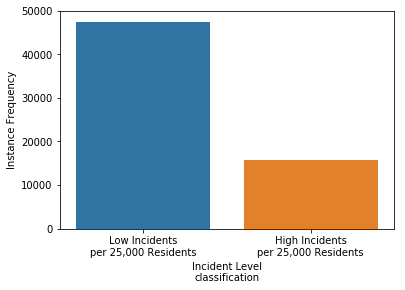

There are 15,786 (25.0%) instances of high incidents and 47,545 (75.0%) instances of low incidents


In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline  

g = sns.countplot(x="high_loi", data=df_grp)
g.set(xticklabels=["Low Incidents\nper 25,000 Residents", "High Incidents\nper 25,000 Residents"])
g.set(xlabel='Incident Level\nclassification', ylabel='Instance Frequency')

plt.show()

high_days = np.where(df_grp['high_loi']==1)[0].shape[0]
low_days = np.where(df_grp['high_loi']==0)[0].shape[0]

hd_perc = round(1.0 * high_days / (high_days + low_days), 2) * 100
ld_perc = round(1.0 * low_days / (high_days + low_days),2) * 100

print("There are {high:,d} ({hd_perc}%) instances of high incidents and {low:,d} ({ld_perc}%) "
      "instances of low incidents".format(high=high_days
                                          , hd_perc=hd_perc
                                          , low=low_days
                                          , ld_perc=ld_perc))


The class imbalance ratio of 3:1 remains almost identical after transforming our response and modifying the high/low threshold.

---
### Drop More Variables

We drop `daily_incident_count` as it is no longer needed now that we've created `daily_incidents_per_25k_population` and `high_loi`.  We also drop `estimate_total_population` as it is effectively replaced by `population_per_100ksqft`.

In [15]:
df_grp.drop(['daily_incident_count', 'estimate_total_population'] # not needed after feature creation
              ,axis=1
              ,inplace=True)

---
### Create Dummy Variables

We next transform any categorical variables into dummies via one hot encoding.

In [16]:
df_grp = pd.get_dummies(df_grp
                        , columns={"postal_code","day_of_month","month","year","dow"}
                        , prefix={"postal_code":"postal_code_"
                        , "day_of_month":"dom_"
                        , "month":"month_"
                        , "year":"year_"
                        , "dow":"dow_"})

---
### Segregate Validation Data

As noted in the introduction, we will segregate the final 3 months of data in this set for use as a validation set so as to simulate the previously described scenario.

In [17]:
# training & testing set
df_test = df_grp.loc[(df_grp.year__2011.isin([1]) | df_grp.year__2012.isin([1]) | 
                        df_grp.year__2013.isin([1]) | 
                        df_grp.year__2014.isin([1])) | 
                        (df_grp.year__2015.isin([1]) &
                        (df_grp.month__1.isin([1]) |
                        df_grp.month__2.isin([1]) |
                        df_grp.month__3.isin([1]) |
                        df_grp.month__4.isin([1]) |
                        df_grp.month__5.isin([1]) |
                        df_grp.month__6.isin([1]) |
                        df_grp.month__7.isin([1]) |
                        df_grp.month__8.isin([1]) |
                        df_grp.month__9.isin([1])))]

# validation set
df_validate = df_grp.loc[df_grp.year__2015.isin([1]) & 
                         (df_grp.month__10.isin([1]) | 
                          df_grp.month__11.isin([1]) | 
                          df_grp.month__12.isin([1]))]


---
## Scale Features

In order to improve interpretability of our model coefficients (where applicable) we will next standardize some features by removing the mean and scaling to unit variance using the `sklearn`'s `StandardScaler` function.  Additionally, we will scale features for all models so as to preserve our ability to more easily compare models to one another.

We hold out economic features and climate features as we will instead engineer discrete categories from the features using clustering algorithms.

First, we transfer select feature columns to `numpy.ndarray` objects.

In [18]:
# train and test set
# drop features which we DON'T want to standardize
Xs_tst_to_scale = df_test.drop(labels=['consumer_price_index_tx','nonfarm_employment_tx'
                                       ,'unemployment_tx'
                                       ,'single_family_building_permits_tx'
                                       ,'multi_family_building_permits_tx'
                                       ,'existing_single_family_home_sales_tx'
                                       ,'existing_single_family_home_price_tx'
                                       ,'non_residential_building_construction'
                                       ,'total_sales_tax_collections_retail_tx'
                                       ,'total_sales_tax_collections_tx'
                                       ,'retail_gasoline_price_tx'
                                       ,'retail_diesel_price_tx'
                                        ,'precipitation_inches'
                                       ,'mean_temp_f'
                                       ,'high_loi'
                                       ,'daily_incidents_per_25k_population'], axis=1).values

# validation set
# drop features which we DON'T want to standardize
Xs_val_to_scale = df_validate.drop(labels=['consumer_price_index_tx','nonfarm_employment_tx'
                                       ,'unemployment_tx'
                                       ,'single_family_building_permits_tx'
                                       ,'multi_family_building_permits_tx'
                                       ,'existing_single_family_home_sales_tx'
                                       ,'existing_single_family_home_price_tx'
                                       ,'non_residential_building_construction'
                                       ,'total_sales_tax_collections_retail_tx'
                                       ,'total_sales_tax_collections_tx'
                                       ,'retail_gasoline_price_tx'
                                       ,'retail_diesel_price_tx'
                                        ,'precipitation_inches'
                                       ,'mean_temp_f'
                                       ,'high_loi'
                                       ,'daily_incidents_per_25k_population'], axis=1).values

Import `StandardScaler` from `sklearn` for conversion of feature values to z-scores.

In [19]:
from sklearn.preprocessing import StandardScaler

Instantiate `StandardScaler` object and fit to data.

In [20]:
scaler = StandardScaler()
scaler.fit(Xs_tst_to_scale)

StandardScaler(copy=True, with_mean=True, with_std=True)

Transform $Xs$ to z-scores.

In [21]:
Xs_tst_scaled = scaler.transform(Xs_tst_to_scale)
Xs_val_scaled = scaler.transform(Xs_val_to_scale)

---
## Final Data Set Description

Data are obtained from the following sources:

| ID | Name | Organization | Source Link |
|:---|:---|:---|
| 1 | Incident Reports Database  | City of Austin Police Department  | https://www.austintexas.gov/police/reports/index.cfm |
| 2 |  Key Economic Indicators Database | Texas Comptroller of Public Accounts | 	https://www.comptroller.texas.gov/economy/key-indicators/ |
| 3 |  Climate Data Online | NOAA National Centers for Environmental Information | https://www.ncdc.noaa.gov/cdo-web/ |
| 4 |  American Fact Finder  | US Census Bureau | https://factfinder.census.gov |


#### Source 1 - Incident Reports Database
The core data of this set is a collection of facts from incidents and/or  offenses responded to and reported on by the city police in Austin, Texas.  This set is published from the incidents reporting database, and is a selection of attributes for each incident from those reports.  These data are collected as part of the routine policing process, and is published for both practical purposes (i.e. legal records, police staffing, patrol location, et cetera) as well as the purposes of transparency to the public with regard to the policing activities in the city of Austin.  These data cover a time period extending from January 1, 2011 to December 31, 2015. 

#### Source 2 - Key Economic Indicators Database
Data from source 2 (Key Economic Indicators) consist of economic indicators for the state of Texas as identified and reported by the State of Texas Comptroller of Public Accounts for the month in which the incident/offense was reported.  These attributes were appended to the set as economic cycles may influence the nature and frequency of incidents and offenses to which the APD responds, a hypothesis for which there exists a large body of study. [1][2][3][4][5]  

#### Source 3 - Climate Data Online
Data from source 3 (Climate Data Online) are climate measurements for the Austin, TX region corresponding to the date (day) of the incident/offense.  These attributes were appended as there are relationships between weather/climate and crime. [5][6][7][8]  

#### Source 4 - American Fact Finder
Data from source 4 (American Fact Finder) are demographic attributes for postal codes for the year in which the incident/offense occurred.  These attributes were appended as there known relationships between population size and density.  [9][10]

#### Variable Descriptions

| Variable | Data Type | Level of Measurement | Description | Variable Type | 
| :------: |  :------ |  :------ |  :------ |  :------ | 
| consumer_price_index_tx | float64 | Ratio | Economic indicator measuring the average change over a reference base period of time | Feature | 
| nonfarm_employment_tx | float64 | Ratio | Represents the number of persons who work and are on the payroll of nonagricultural establishments in TX. | Feature | 
| unemployment_tx | float64 | Ratio | Represents a percentage of the civilian labor force that is unemployed in TX. | Feature | 
| single_family_building_permits_tx | int64 | Ratio | Represents data on new privately-owned residential construction. The data only shows information on single-family building permits issued for new construction. The number of permits issued does not necessarily mean that the same number of residential structures will be built. | Feature | 
| multi_family_building_permits_tx | int64 | Ratio | Represents data on new privately-owned residential construction. The data only shows information on multi-family building permits issued for new construction. The number of permits issued does not necessarily mean that the same number of residential structures will be built. | Feature | 
| existing_single_family_home_sales_tx | int64 | Ratio | Total Single Family Home Sales in a one month period in the state of TX. | Feature | 
| existing_single_family_home_price_tx | int64 | Ratio | Median Single Family Home Price over a one month period in the state of TX. | Feature | 
| non_residential_building_construction | float64 | Ratio | The value of construction starts for non-residential construction in the state of TX over a one month period of time. | Feature | 
| total_sales_tax_collections_retail_tx | float64 | Ratio | Total sales tax collected in Texas from retailers over a one month period. | Feature | 
| total_sales_tax_collections_tx | float64 | Ratio | Total sales tax collected in Texas over a one month period. | Feature | 
| retail_gasoline_price_tx | float64 | Ratio | Average price of gasoline at the pump paid by TX consumers. | Feature | 
| retail_diesel_price_tx | float64 | Ratio | Average price paid by TX consumers for diesel fuel at the pump. | Feature | 
| precipitation_inches | float64 | Ratio | Mean daily air temperature on the date of the incident in and around Austin as measured by seven Austin area NOAA weather stations. | Feature | 
| mean_temp_f | float64 | Interval | Mean daily precipitation on the date of the incident in and around Austin as measured by seven Austin area NOAA weather stations. | Feature | 
| population_per_100ksqft | float64 | Ratio | Estimated total population of a given zip code per 100,000 square feet.  Measure of population density. | Feature | 
| dow__0 | uint8 | Interval | Indicator variable for day of week = Sunday | Feature | 
| dow__1 | uint8 | Interval | Indicator variable for day of week = Monday | Feature | 
| dow__2 | uint8 | Interval | Indicator variable for day of week = Tuesday | Feature | 
| dow__3 | uint8 | Interval | Indicator variable for day of week = Wednesday | Feature | 
| dow__4 | uint8 | Interval | Indicator variable for day of week = Thursday | Feature | 
| dow__5 | uint8 | Interval | Indicator variable for day of week = Friday | Feature | 
| dow__6 | uint8 | Interval | Indicator variable for day of week = Saturday | Feature | 
| year__2011 | uint8 | Interval | Indicator variable for year = 2011 | Feature | 
| year__2012 | uint8 | Interval | Indicator variable for year = 2012 | Feature | 
| year__2013 | uint8 | Interval | Indicator variable for year = 2013 | Feature | 
| year__2014 | uint8 | Interval | Indicator variable for year = 2014 | Feature | 
| year__2015 | uint8 | Interval | Indicator variable for year = 2015 | Feature | 
| postal_code__75078 | uint8 | Interval | Indicator variable for postal code = 75078 | Feature | 
| postal_code__78610 | uint8 | Interval | Indicator variable for postal code = 78610 | Feature | 
| postal_code__78612 | uint8 | Interval | Indicator variable for postal code = 78612 | Feature | 
| postal_code__78613 | uint8 | Interval | Indicator variable for postal code = 78613 | Feature | 
| postal_code__78615 | uint8 | Interval | Indicator variable for postal code = 78615 | Feature | 
| postal_code__78616 | uint8 | Interval | Indicator variable for postal code = 78616 | Feature | 
| postal_code__78617 | uint8 | Interval | Indicator variable for postal code = 78617 | Feature | 
| postal_code__78621 | uint8 | Interval | Indicator variable for postal code = 78621 | Feature | 
| postal_code__78641 | uint8 | Interval | Indicator variable for postal code = 78641 | Feature | 
| postal_code__78645 | uint8 | Interval | Indicator variable for postal code = 78645 | Feature | 
| postal_code__78652 | uint8 | Interval | Indicator variable for postal code = 78652 | Feature | 
| postal_code__78653 | uint8 | Interval | Indicator variable for postal code = 78653 | Feature | 
| postal_code__78660 | uint8 | Interval | Indicator variable for postal code = 78660 | Feature | 
| postal_code__78664 | uint8 | Interval | Indicator variable for postal code = 78664 | Feature | 
| postal_code__78665 | uint8 | Interval | Indicator variable for postal code = 78665 | Feature | 
| postal_code__78681 | uint8 | Interval | Indicator variable for postal code = 78681 | Feature | 
| postal_code__78701 | uint8 | Interval | Indicator variable for postal code = 78701 | Feature | 
| postal_code__78702 | uint8 | Interval | Indicator variable for postal code = 78702 | Feature | 
| postal_code__78703 | uint8 | Interval | Indicator variable for postal code = 78703 | Feature | 
| postal_code__78704 | uint8 | Interval | Indicator variable for postal code = 78704 | Feature | 
| postal_code__78705 | uint8 | Interval | Indicator variable for postal code = 78705 | Feature | 
| postal_code__78712 | uint8 | Interval | Indicator variable for postal code = 78712 | Feature | 
| postal_code__78717 | uint8 | Interval | Indicator variable for postal code = 78717 | Feature | 
| postal_code__78719 | uint8 | Interval | Indicator variable for postal code = 78719 | Feature | 
| postal_code__78721 | uint8 | Interval | Indicator variable for postal code = 78721 | Feature | 
| postal_code__78722 | uint8 | Interval | Indicator variable for postal code = 78722 | Feature | 
| postal_code__78723 | uint8 | Interval | Indicator variable for postal code = 78723 | Feature | 
| postal_code__78724 | uint8 | Interval | Indicator variable for postal code = 78724 | Feature | 
| postal_code__78725 | uint8 | Interval | Indicator variable for postal code = 78725 | Feature | 
| postal_code__78726 | uint8 | Interval | Indicator variable for postal code = 78726 | Feature | 
| postal_code__78727 | uint8 | Interval | Indicator variable for postal code = 78727 | Feature | 
| postal_code__78728 | uint8 | Interval | Indicator variable for postal code = 78728 | Feature | 
| postal_code__78729 | uint8 | Interval | Indicator variable for postal code = 78729 | Feature | 
| postal_code__78730 | uint8 | Interval | Indicator variable for postal code = 78730 | Feature | 
| postal_code__78731 | uint8 | Interval | Indicator variable for postal code = 78731 | Feature | 
| postal_code__78732 | uint8 | Interval | Indicator variable for postal code = 78732 | Feature | 
| postal_code__78733 | uint8 | Interval | Indicator variable for postal code = 78733 | Feature | 
| postal_code__78734 | uint8 | Interval | Indicator variable for postal code = 78734 | Feature | 
| postal_code__78735 | uint8 | Interval | Indicator variable for postal code = 78735 | Feature | 
| postal_code__78736 | uint8 | Interval | Indicator variable for postal code = 78736 | Feature | 
| postal_code__78737 | uint8 | Interval | Indicator variable for postal code = 78737 | Feature | 
| postal_code__78738 | uint8 | Interval | Indicator variable for postal code = 78738 | Feature | 
| postal_code__78739 | uint8 | Interval | Indicator variable for postal code = 78739 | Feature | 
| postal_code__78741 | uint8 | Interval | Indicator variable for postal code = 78741 | Feature | 
| postal_code__78742 | uint8 | Interval | Indicator variable for postal code = 78742 | Feature | 
| postal_code__78744 | uint8 | Interval | Indicator variable for postal code = 78744 | Feature | 
| postal_code__78745 | uint8 | Interval | Indicator variable for postal code = 78745 | Feature | 
| postal_code__78746 | uint8 | Interval | Indicator variable for postal code = 78746 | Feature | 
| postal_code__78747 | uint8 | Interval | Indicator variable for postal code = 78747 | Feature | 
| postal_code__78748 | uint8 | Interval | Indicator variable for postal code = 78748 | Feature | 
| postal_code__78749 | uint8 | Interval | Indicator variable for postal code = 78749 | Feature | 
| postal_code__78750 | uint8 | Interval | Indicator variable for postal code = 78750 | Feature | 
| postal_code__78751 | uint8 | Interval | Indicator variable for postal code = 78751 | Feature | 
| postal_code__78752 | uint8 | Interval | Indicator variable for postal code = 78752 | Feature | 
| postal_code__78753 | uint8 | Interval | Indicator variable for postal code = 78753 | Feature | 
| postal_code__78754 | uint8 | Interval | Indicator variable for postal code = 78754 | Feature | 
| postal_code__78756 | uint8 | Interval | Indicator variable for postal code = 78756 | Feature | 
| postal_code__78757 | uint8 | Interval | Indicator variable for postal code = 78757 | Feature | 
| postal_code__78758 | uint8 | Interval | Indicator variable for postal code = 78758 | Feature | 
| postal_code__78759 | uint8 | Interval | Indicator variable for postal code = 78759 | Feature | 
| postal_code__78945 | uint8 | Interval | Indicator variable for postal code = 78945 | Feature | 
| dom__1 | uint8 | Interval | Indicator variable for day of month = 1 | Feature | 
| dom__2 | uint8 | Interval | Indicator variable for day of month = 2 | Feature | 
| dom__3 | uint8 | Interval | Indicator variable for day of month = 3 | Feature | 
| dom__4 | uint8 | Interval | Indicator variable for day of month = 4 | Feature | 
| dom__5 | uint8 | Interval | Indicator variable for day of month = 5 | Feature | 
| dom__6 | uint8 | Interval | Indicator variable for day of month = 6 | Feature | 
| dom__7 | uint8 | Interval | Indicator variable for day of month = 7 | Feature | 
| dom__8 | uint8 | Interval | Indicator variable for day of month = 8 | Feature | 
| dom__9 | uint8 | Interval | Indicator variable for day of month = 9 | Feature | 
| dom__10 | uint8 | Interval | Indicator variable for day of month = 10 | Feature | 
| dom__11 | uint8 | Interval | Indicator variable for day of month = 11 | Feature | 
| dom__12 | uint8 | Interval | Indicator variable for day of month = 12 | Feature | 
| dom__13 | uint8 | Interval | Indicator variable for day of month = 13 | Feature | 
| dom__14 | uint8 | Interval | Indicator variable for day of month = 14 | Feature | 
| dom__15 | uint8 | Interval | Indicator variable for day of month = 15 | Feature | 
| dom__16 | uint8 | Interval | Indicator variable for day of month = 16 | Feature | 
| dom__17 | uint8 | Interval | Indicator variable for day of month = 17 | Feature | 
| dom__18 | uint8 | Interval | Indicator variable for day of month = 18 | Feature | 
| dom__19 | uint8 | Interval | Indicator variable for day of month = 19 | Feature | 
| dom__20 | uint8 | Interval | Indicator variable for day of month = 20 | Feature | 
| dom__21 | uint8 | Interval | Indicator variable for day of month = 21 | Feature | 
| dom__22 | uint8 | Interval | Indicator variable for day of month = 22 | Feature | 
| dom__23 | uint8 | Interval | Indicator variable for day of month = 23 | Feature | 
| dom__24 | uint8 | Interval | Indicator variable for day of month = 24 | Feature | 
| dom__25 | uint8 | Interval | Indicator variable for day of month = 25 | Feature | 
| dom__26 | uint8 | Interval | Indicator variable for day of month = 26 | Feature | 
| dom__27 | uint8 | Interval | Indicator variable for day of month = 27 | Feature | 
| dom__28 | uint8 | Interval | Indicator variable for day of month = 28 | Feature | 
| dom__29 | uint8 | Interval | Indicator variable for day of month = 29 | Feature | 
| dom__30 | uint8 | Interval | Indicator variable for day of month = 30 | Feature | 
| dom__31 | uint8 | Interval | Indicator variable for day of month = 31 | Feature | 
| month__1 | uint8 | Interval | Indicator variable for day of month = 1 | Feature | 
| month__2 | uint8 | Interval | Indicator variable for day of month = 2 | Feature | 
| month__3 | uint8 | Interval | Indicator variable for day of month = 3 | Feature | 
| month__4 | uint8 | Interval | Indicator variable for day of month = 4 | Feature | 
| month__5 | uint8 | Interval | Indicator variable for day of month = 5 | Feature | 
| month__6 | uint8 | Interval | Indicator variable for day of month = 6 | Feature | 
| month__7 | uint8 | Interval | Indicator variable for day of month = 7 | Feature | 
| month__8 | uint8 | Interval | Indicator variable for day of month = 8 | Feature | 
| month__9 | uint8 | Interval | Indicator variable for day of month = 9 | Feature | 
| month__10 | uint8 | Interval | Indicator variable for day of month = 10 | Feature | 
| month__11 | uint8 | Interval | Indicator variable for day of month = 11 | Feature | 
| month__12 | uint8 | Interval | Indicator variable for day of month = 12 | Feature | 
| high_loi | int64 | Interval | Binary response variable indicating whether the daily incident count for a given date and postal code exceeded the threshold of 17 incidents per 25,000. | Classification Target | 

#### Summary

Our final data set consists of 63,331 instances of 131 feature variables and 1 response variable.  60,2013 instances are allocated to the training and testing set, and 3,228 instances are allocated to the validation set.

## Visualize Important Attributes

### Economic Variables

We will attempt to engineer new features by clustering the subset of economic variables.  Thus, we visualize and analyze those variables specifically.

In [22]:
#group by columns
grp_pairplot = ['consumer_price_index_tx'
            ,'nonfarm_employment_tx'
            ,'unemployment_tx'
            ,'single_family_building_permits_tx'
            ,'multi_family_building_permits_tx'
            ,'existing_single_family_home_sales_tx'
            ,'existing_single_family_home_price_tx'
            ,'non_residential_building_construction'
            ,'total_sales_tax_collections_retail_tx'
            ,'total_sales_tax_collections_tx'
            ,'retail_gasoline_price_tx'
            ,'retail_diesel_price_tx']
          
df_grppairplot = df_test[grp_pairplot]

df_grppairplot = df_grppairplot.sample(5000)


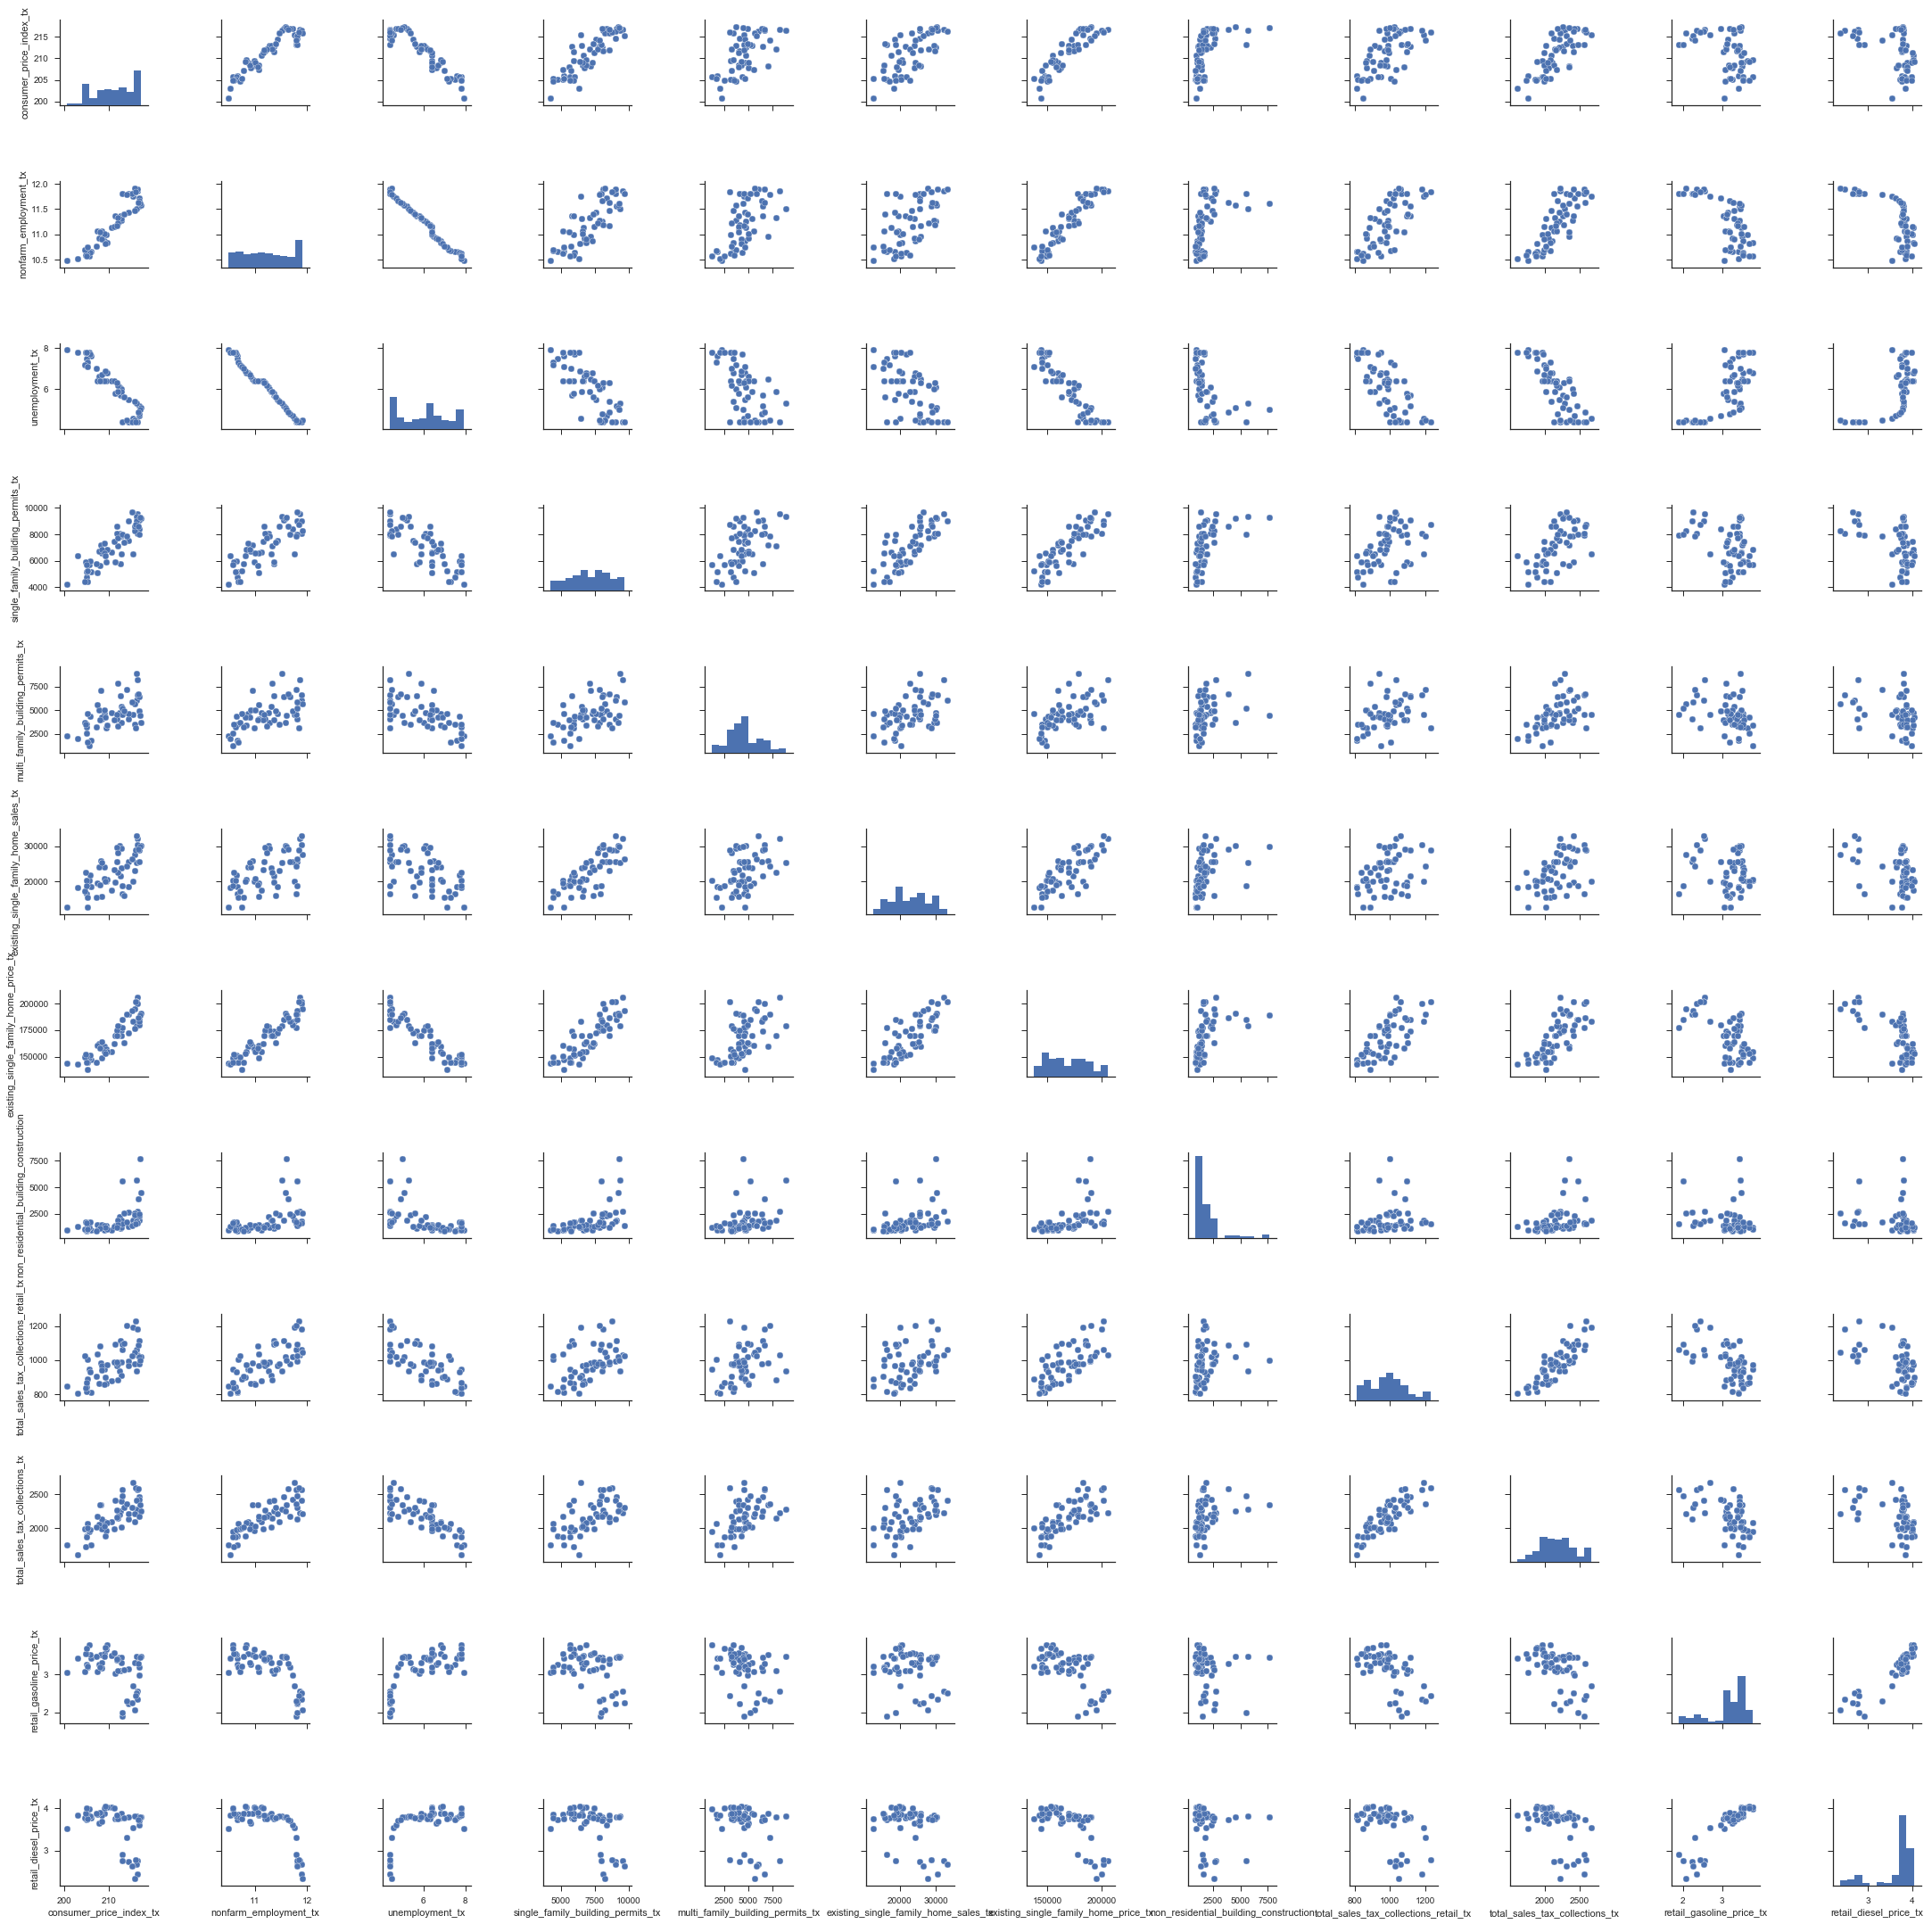

In [23]:
sns.set(style="ticks", color_codes=True)
g1 = sns.pairplot(df_grppairplot)
plt.show()

As one can see in the above pair plots , many of the 12 economic variables are correlated. Some, as expected, look to be highly correlated like unemployment and non-farm employment, non-farm employment and consumer price index, sales tax retail and total sales tax . While most correlations are logical/obvious some are more intriguing such as single family home prices and single family building permits. One can also notice that multifamily building permits are also correlated to single family home prices (although not as strongly correlated). This could suggest that the housing market is efficient and tries to correct itself. As the home prices rise, building permits increase for single family and multi family developments but it also suggests that single family homes are most easily substituted by other new single family homes. 

### Climate Variables

We will also attempt to engineer new features by clustering the subset of climate variables. Thus, we visualize and analyze those variables specifically as well.

In [24]:
#group by columns
grp_pairplot2 = ['precipitation_inches'
            ,'mean_temp_f']
          
df_grppairplot2 = df[grp_pairplot2]

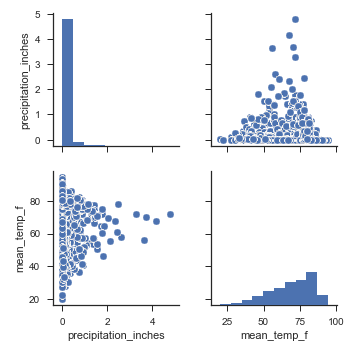

In [25]:
sns.set(style="ticks", color_codes=True)
g2 = sns.pairplot(df_grppairplot2)
plt.show()

Temperature and precipitation show much less linear correlation that the economic variables.  One observable phenomenon is that the higherst precipitation observations tend to occur between 50 and 100 degrees Fahrenheit.  There may be some meteorlogical explanation for this phenomenon, but if so, it is beyond the knowledge of the authors.

The histogram of precipitation shows an extremely right skewness. Mean temp is left skewed, with a mode around 75 degrees Fahrenheit.

---

## Cross Validation Strategy

For our cross validation splitting strategy, we employ stratified $k$-fold cross validation.  In $k$-fold cross-validation the data is first divided into $k$ approximately equal sized folds. Next, $k$ loops of training and testing are performed such that for each loop a different fold of the data is witheld for testing while the other $k - 1$ folds are used for training.

Because our data are imbalanced, the stratified $k$-folds method is superior for our uses. In the $k$-folds method, the subsamples (folds) are selected so as to roughly maintain the class proportions of the whole sample.  In this way training and testing occurs against representative proportions of the two classes.  We selected $k=10$ for the stratified cross validation of our models as this number of folds tends to reduce variance while remaining mostly unbiased.  [2]


The figure below depicts the stratified $k$-fold strategy for our binary class imbalance ratio.

![](img/stratified-k-fold-cv.png)

### Create Cross Validation Object

We next create the `StratifiedKFold` object, which implements the cross validation strategy described above.

In [26]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, random_state=42) #k-folds = 10

print(cv)

StratifiedKFold(n_splits=10, random_state=42, shuffle=False)


### Segment Features for Clustering

We identify and segregate the features which are to be clustered to engineer new features.  The two groups are the economic variables and the climate variables of our feature set.

In [27]:
Xs_econ_tst_to_cluster = df_test[['consumer_price_index_tx'
                                  ,'nonfarm_employment_tx'
                                  ,'unemployment_tx'
                                  ,'single_family_building_permits_tx'
                                  ,'multi_family_building_permits_tx'
                                  ,'existing_single_family_home_sales_tx'
                                  ,'existing_single_family_home_price_tx'
                                  ,'non_residential_building_construction'
                                  ,'total_sales_tax_collections_retail_tx'
                                  ,'total_sales_tax_collections_tx'
                                  ,'retail_gasoline_price_tx'
                                  ,'retail_diesel_price_tx']].values

Xs_econ_val_to_cluster = df_validate[['consumer_price_index_tx'
                                  ,'nonfarm_employment_tx'
                                  ,'unemployment_tx'
                                  ,'single_family_building_permits_tx'
                                  ,'multi_family_building_permits_tx'
                                  ,'existing_single_family_home_sales_tx'
                                  ,'existing_single_family_home_price_tx'
                                  ,'non_residential_building_construction'
                                  ,'total_sales_tax_collections_retail_tx'
                                  ,'total_sales_tax_collections_tx'
                                  ,'retail_gasoline_price_tx'
                                  ,'retail_diesel_price_tx']].values

In [28]:
Xs_climate_tst_to_cluster = df_test[['precipitation_inches'
                                     ,'mean_temp_f']].values

Xs_climate_val_to_cluster = df_validate[['precipitation_inches'
                                         ,'mean_temp_f']].values

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# Feature Engineering Using Clustering

## AdaBoost Baseline Measurement

To determine the efficacy of our feature engineering, we take a baseline measurement of the composite score from the best performing classifier, AdaBoost, in the configuration which was determined as optimal in laboratory 2.

Import `DecisionTreeClassifier`, which will be used as the base estimator for the AdaBoost ensemble method. Also import the `AdaBoostClassifier`.

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# best configuration of AdaBoost from Lab 2
best_ab_clf = AdaBoostClassifier(algorithm='SAMME.R',
                                 base_estimator=DecisionTreeClassifier(class_weight=None
                                                ,criterion='gini'
                                                ,max_depth=1
                                                ,max_features=None
                                                ,max_leaf_nodes=None
                                                ,min_impurity_decrease=0.0
                                                ,min_impurity_split=None
                                                ,min_samples_leaf=1
                                                ,min_samples_split=2
                                                ,min_weight_fraction_leaf=0.0
                                                ,presort=False
                                                , random_state=None
                                                ,splitter='best')
                                 ,learning_rate=0.99
                                 ,n_estimators=50
                                 ,random_state=None)

Next, we train and test the classifier under the stratified 10-fold scheme we describe above.  We calculate the mean composite score and its standard deviation for the  10 folds.

In [30]:
scaler = StandardScaler()
Xs_baseline = df_test.drop(["daily_incidents_per_25k_population","high_loi"], axis=1)
scaler.fit(Xs_baseline.values)

# numpy arrays of the scaled Xs and the response
Xs_baseline_scaled = scaler.transform(Xs_baseline.values)
y_test = df_test['high_loi'].values

In [31]:
%%time

from sklearn.model_selection import cross_val_score

cscore = cross_val_score(best_ab_clf
                         ,Xs_baseline_scaled
                         ,y=y_test
                         ,cv=cv
                         ,scoring=comp_scorer)

print ("Average composite score = ", cscore.mean()*100, "+/-", cscore.std()*100)

Average composite score =  76.76866959770886 +/- 15.368661247593646
CPU times: user 4min 16s, sys: 2.38 s, total: 4min 19s
Wall time: 43.7 s


<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>

# Feature Engineering
## Using KMeans and DBSCAN

We will evaluate three different clustering methods as we seek to engineer two new feature groups:  categorical dummy variables generated from a clustering algorithm which will take the economic variables as an input, and categorical dummy variables generated from a clustering algorithm which will take the climate variables as an input.

### K-Means

The K-means algorithm attempts to group data instances into clusters that are defined and well separated.  The clusters are based on a measure of center called a centroid.  Each centroid represents the mean (or, sometimes, the median) of the points in the cluster.  Various measures of closeness can be used to determine similarity but Euclidian distance is typically used.  Inertia measures how well organized the clusters are by calculating the sum of squares of the distance of each point from the mean ($SSE$).

The steps of the algorithm are as follows:
1. Choose initial centroids — Select $N$ samples to be averaged to create K cluster centroids.
2. Update centroids — New sample groups are created by determining the closeness of each instance to the existing centroids.  Then the centroids are updated by calculating the means of the new sample groups.
3. Repeat updating centroids — The centroids are continually updated until there is no further change in the clusters or until a stopping criterion is met.

Correctly finding the global minimum inertia value is highly dependent on initial selection of the centroids.  Selecting initial centroids that are distant from each other improves the likelihood of finding the global minimum inertia value.  Re-running the algorithm a number of times using different centroid seeds and taking the best result is another method of improving the likelihood of finding the global minimum value.

The K-means method scales to large data and is extremely fast with complexity determined by number of observations, clusters, iterations, and attributes.  K-means functions best when cluster sizes are balanced, clusters have equal densities, and the shape of the clusters is globular (or spherical).

The `scikit learn` implementation of K-means algorithm requires several inputs: number of clusters, method of initial cluster selection, number of algorithm restarts, and a stopping criterion.  For this analysis we are going to fix the method of initial cluster selection using the k-means++ method which is generally known to be superior to random initialization.  The parameters that we are using as hyper-parameters are number of clusters (`n_clusters`), number of clustering restarts (`n_init`), and the maximum number of iterations (`max_iter`), which we are using as our stopping criterion.

In [32]:
%%time

from sklearn.cluster import KMeans # import k-means

for k1 in range(3, 5): # k's from 3 to 5
    for k2 in range(3, 5): # k's from 3 to 5
        
        clskm1 = KMeans(n_clusters=k1, init="k-means++", random_state=1)
        clskm1.fit(Xs_climate_tst_to_cluster)
        newfeature_climate = clskm1.labels_

        clskm2 = KMeans(n_clusters=k2, init="k-means++", random_state=1)
        clskm2.fit(Xs_econ_tst_to_cluster)
        newfeature_econ = clskm2.labels_

        X = np.column_stack((Xs_tst_scaled, pd.get_dummies(newfeature_climate), pd.get_dummies(newfeature_econ)))

        cscore = cross_val_score(best_ab_clf, X, y=y_test,cv=cv, scoring=comp_scorer)

        print("__________________________")
        print("k1=",k1,"k2=",k2)
        print ("Average composite score = ", cscore.mean()*100, "+-", cscore.std()*100)

__________________________
k1= 3 k2= 3
Average composite score =  86.4449062934287 +- 2.5693688938833312
__________________________
k1= 3 k2= 4
Average composite score =  86.59743666096678 +- 2.908256478777982
__________________________
k1= 4 k2= 3
Average composite score =  86.79445347213596 +- 2.2933072729570565
__________________________
k1= 4 k2= 4
Average composite score =  86.48936311026026 +- 2.9471148013074893
CPU times: user 14min 9s, sys: 7.03 s, total: 14min 16s
Wall time: 2min 23s


The resulting output shows us that the mean composite score is improved over the baseline when engineering economic and climate features using k-means.  However, the values of the mean composite scores are highly similar as $k$ was varied between $3$ and $4$ for both clusters.

The primary hyperparameter of the k-means algorith, $k$, is set by the user. So, some sort of method is needed to ensure that the value of k is ideal. While there are several methods, the method chosen for this project is referred to as the “Elbow Method”. This involves plotting the average distance to each cluster vs the number of clusters. As the clusters increment, the distance between the clusters grows smaller. With the elbow method, we look for a value of k where the distance stops to change drastically. This results in a bend in the resulting plot which is referred to as the elbow.

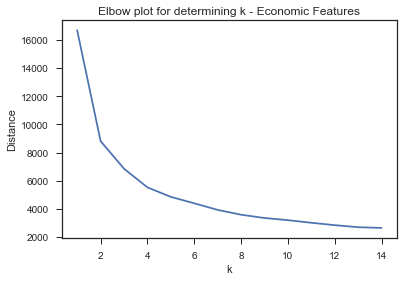

In [33]:
#Determine k for economic clustering.

from scipy.spatial.distance import cdist

plt.plot()
#colors = ['b', 'g', 'r']
#markers = ['o', 'v', 's']
 
distance = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Xs_econ_tst_to_cluster)
    kmeanModel.fit(Xs_econ_tst_to_cluster)
    distance.append(sum(np.min(cdist(Xs_econ_tst_to_cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('Elbow plot for determining k - Economic Features')
plt.show()

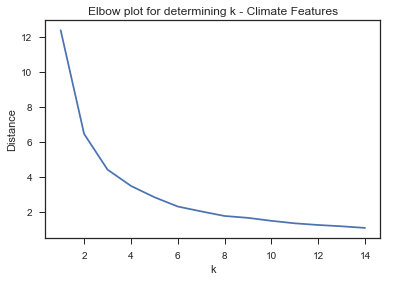

In [34]:
#Determine k for climate clustering.

from scipy.spatial.distance import cdist

plt.plot()
#colors = ['b', 'g', 'r']
#markers = ['o', 'v', 's']
 
distance = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Xs_climate_tst_to_cluster)
    kmeanModel.fit(Xs_climate_tst_to_cluster)
    distance.append(sum(np.min(cdist(Xs_climate_tst_to_cluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('Elbow plot for determining k - Climate Features')
plt.show()

The optimal values of k ended up being 4 for each of our datasets.

Next, we visualize the k-means clustering results for the economic variables.

In [35]:
# optimal k for climate vars
clskm1 = KMeans(n_clusters=4, init="k-means++", random_state=1)
clskm1.fit(Xs_climate_tst_to_cluster)
newfeature_climate = clskm1.labels_

# optimal k for econ vars
clskm2 = KMeans(n_clusters=4, init="k-means++", random_state=1)
clskm2.fit(Xs_econ_tst_to_cluster)
newfeature_econ = clskm2.labels_

In [36]:
df_grppairplot = df_test[grp_pairplot]

df_grppairplot['km_econ_cluster'] = newfeature_econ

df_grppairplot = df_grppairplot.sample(5000)


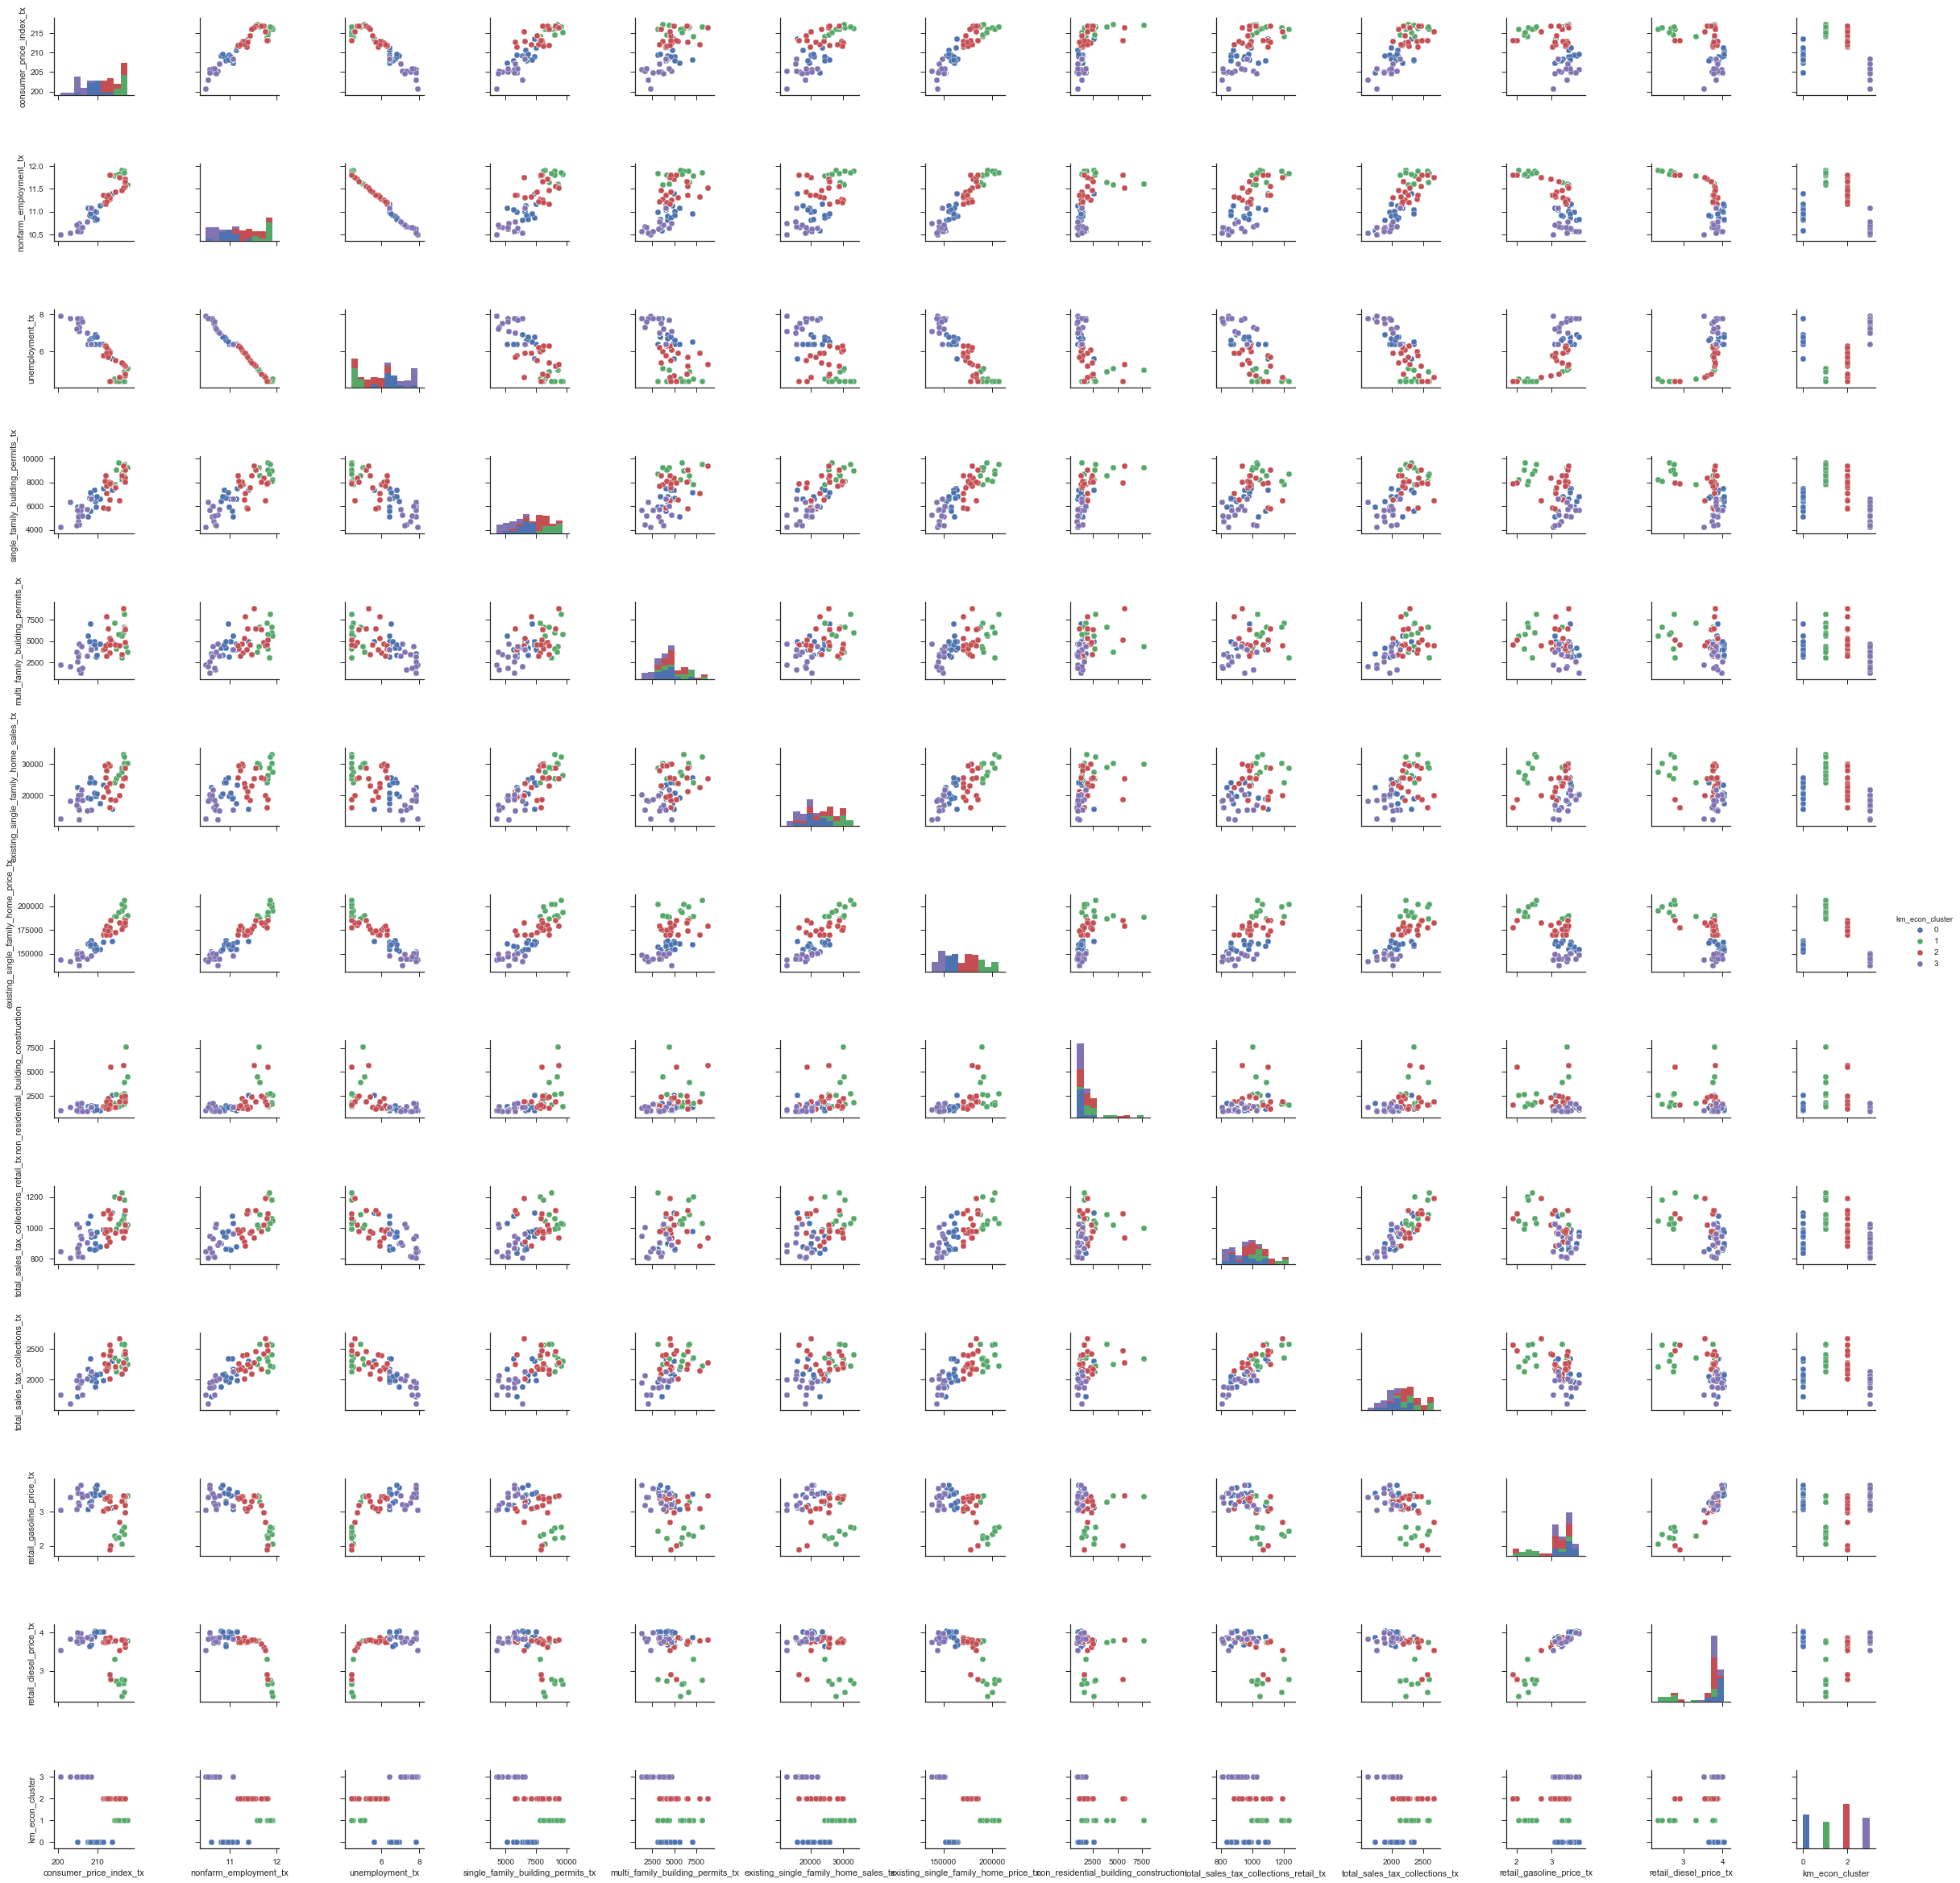

In [37]:
sns.set(style="ticks", color_codes=True)
g3 = sns.pairplot(df_grppairplot, hue='km_econ_cluster')
plt.show()

For economic variables, the 4 clusters are the most distinct in relation to existing single family home pricing.

In [38]:
df_grppairplot2 = df_test[grp_pairplot2]

df_grppairplot2['km_climate_cluster'] = newfeature_climate

df_grppairplot2 = df_grppairplot2.sample(5000)


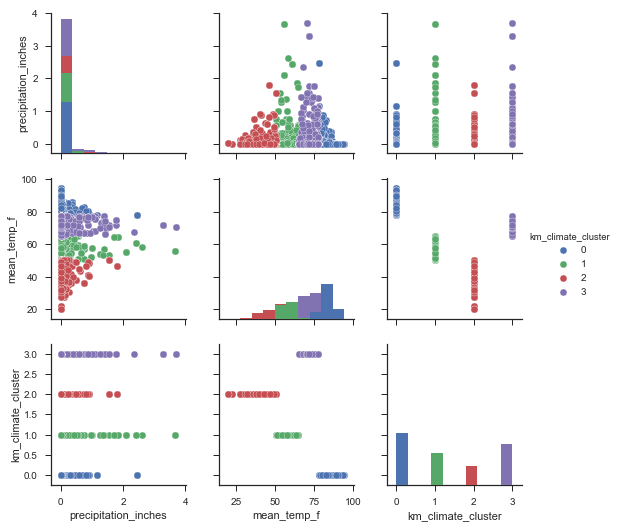

In [39]:
sns.set(style="ticks", color_codes=True)
g4 = sns.pairplot(df_grppairplot2, hue='km_climate_cluster')
plt.show()

The clusters for the climate variables are most distinct in relation to temperature. One can notice clear differentiation at 50 and below, ~51 to 60, ~61 to 80, and above 80. 

### DBSCAN
 
DBSCAN uses density as the basis for determining clusters.  The DBSCAN algorithm uses three designations for data points (or samples): core, border, and noise.  A core point is where there are a minimum number of other core points within a specific radius.  A border point is a point that is near other core points but does not have the minimum number of other core points within the defined radius to be considered a true core point.  Noise points, which are considered to be outliers, are any points not considered to be a core point or a border point.

DBSCAN defines clusters to be areas of high density which are differentiated from other clusters by areas of low density.  The DBSCAN algorithm is deterministic in that there is a single solution which determines the number of clusters.  This also means that there is no need to rerun the algorithm for the purpose of improving the clustering results.  Even though DBSCAN is deterministic, the order in which the data is introduced will create variations in the results; so, the sort order of the data can be an important factor to consider when using this method.

Because the algorithm is density based (versus centroid based), the clusters can take any shape and clusters can be found inside other clusters.  

DBSCAN uses two inputs to recursively grow the clusters.  The first is a distance radius around each point called the eps.  The second is the minimum number of points (`min_samples`) around each point (within its eps) to be considered a core point.  All data points begin the algorithm as unclassified.  For every data point in the dataset the number of points in its eps are counted.  Beginning with the first data point, if the number of points in its eps is more than the `min_samples` then that point is designated as belonging to a cluster as well as all the points within its eps.  Clusters are then expanded by repeating the same process of counting and designating points to clusters.  If an individual point has less than the `min_samples` within its eps and is not in the neighborhood of another clustered core point, it is designated to be noise and is ignored.

For our analysis we will be focusing on `eps` and `min_samples` as our hyper-parameters.

In [40]:
%%time

from sklearn.cluster import DBSCAN

cls1 = DBSCAN(n_jobs=-1,min_samples=100)
cls1.fit(Xs_climate_tst_to_cluster)
newfeature_climate_dbscan = cls1.labels_

cls2 = DBSCAN(n_jobs=-1,min_samples=1100)
cls2.fit(Xs_econ_tst_to_cluster)
newfeature_econ_dbscan = cls2.labels_

X = np.column_stack((Xs_tst_scaled
                     ,pd.get_dummies(newfeature_climate_dbscan)
                     ,pd.get_dummies(newfeature_econ_dbscan)))

cscore = cross_val_score(best_ab_clf, X, y=y_test,cv=cv, scoring=comp_scorer)
print ("Average composite score = ", cscore.mean()*100, "+-", cscore.std()*100)

Average composite score =  82.60946893895466 +- 5.665788768594366
CPU times: user 3min 49s, sys: 2.23 s, total: 3min 51s
Wall time: 41.5 s


Running dbscan with the default settings resulted in 47 clusters for climate and 56 clusters for economics. Climate mainly just clustered to one with tens of thousands in one cluster and then just a handful in the others. Re-running dbscan with a minimum of 100 samples in climate led to a reduction of clusters to 9. This is due to the fact that vast majority of the time, Austin has consistent weather. Also, clustering on economic features led to many classes with minimum sample size which was originally 100. Changing minimum samples to 1,000 reduced the clusters to 11. Also, changing minimum samples to 100 in climate reduced the clusters to 9. This class imbalance was not seen in k means clustering. K means resulted in much more balanced classes. Distance for all of these algorithms was Euclidean, which was chosen as the data is not sparse.

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>
# Final Comparison of Clustering Methods

Print the mean composite score of the AdaBoost classifier using the original features, but against the validation (hold out) data set.

In [41]:
Xs_validate = df_validate.drop(["daily_incidents_per_25k_population","high_loi"], axis=1)
scaler.transform(Xs_validate.values)

# numpy arrays of the scaled Xs and the response
y_validate = df_validate['high_loi'].values

cscore_validation = cross_val_score(best_ab_clf
                         ,Xs_validate
                         ,y=y_validate
                         ,cv=cv
                         ,scoring=comp_scorer)

print ("Average composite score = ", cscore_validation.mean()*100, "+/-", cscore_validation.std()*100)


Average composite score =  80.87126670876705 +/- 4.030418828091033


Engineer features using k-means against the validation (hold out) data set. Print the mean composite score of the AdaBoost classifier.

In [42]:
# optimal k for climate vars
clskm1 = KMeans(n_clusters=4, init="k-means++", random_state=1)
clskm1.fit(Xs_climate_val_to_cluster)
newfeature_climate_kmeans_val = clskm1.labels_

# optimal k for econ vars
clskm2 = KMeans(n_clusters=4, init="k-means++", random_state=1)
clskm2.fit(Xs_econ_val_to_cluster)
newfeature_econ_kmeans_val = clskm2.labels_

X = np.column_stack((Xs_val_scaled, pd.get_dummies(newfeature_climate_kmeans_val)
                     , pd.get_dummies(newfeature_econ_kmeans_val)))

cscore_kmeans_validation = cross_val_score(best_ab_clf
                                           ,X
                                           ,y=df_validate['high_loi'].values
                                           ,cv=cv
                                           , scoring=comp_scorer)

print ("Average composite score = ", cscore_kmeans_validation.mean()*100, "+-", cscore_kmeans_validation.std()*100)

Average composite score =  78.90778580204334 +- 5.100888630872526


Engineer features using DBSCAN against the validation (hold out) data set. Print the mean composite score of the AdaBoost classifier.

In [43]:

cls1 = DBSCAN(n_jobs=-1,min_samples=100)
cls1.fit(Xs_climate_val_to_cluster)
newfeature_climate_dbscan_val = cls1.labels_

cls2 = DBSCAN(n_jobs=-1,min_samples=1100)
cls2.fit(Xs_econ_val_to_cluster)
newfeature_econ_dbscan_val = cls2.labels_

X = np.column_stack((Xs_val_scaled, pd.get_dummies(newfeature_climate_dbscan_val)
                     , pd.get_dummies(newfeature_econ_dbscan_val)))

cscore_dbscan = cross_val_score(best_ab_clf, X, y=df_validate['high_loi'].values,cv=cv, scoring=comp_scorer)
print ("Average composite score = ", cscore_dbscan.mean()*100, "+-", cscore_dbscan.std()*100)

Average composite score =  77.88962199860777 +- 4.154993032100056


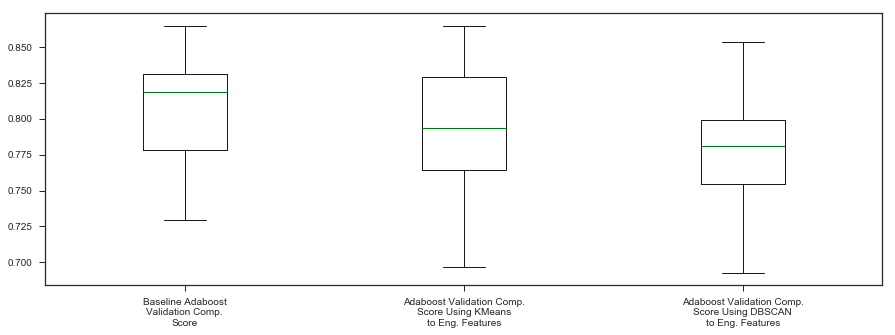

In [44]:
sns.set_palette("dark")
plt.figure(figsize=(15,5))
plt.boxplot([ cscore_validation, cscore_kmeans_validation, cscore_dbscan],
            labels=['Baseline Adaboost\nValidation Comp.\nScore'
                    ,'Adaboost Validation Comp.\nScore Using KMeans\nto Eng. Features'
                    , 'Adaboost Validation Comp.\nScore Using DBSCAN\nto Eng. Features'])

plt.show()

Surprisingly, although the AdaBoost model using features engineered utilizing the K-Means algorithm performed better than the baseline model and the model using DBSCAN created features, all models are very close in composite score when run against data not used in any of the model creation processes.

Next, we perform an ANOVA test to determine if any of the means of the model's resulting composite scores are different at a 95% confidence level.

In [45]:
from scipy import stats

F, p = stats.f_oneway(cscore_validation, cscore_kmeans_validation, cscore_dbscan)

print("The F-statistic from the ANOVA test is {stat}".format(stat=F))
print("The p-value from the ANOVA test is {stat}".format(stat=p))

The F-statistic from the ANOVA test is 1.041867037930825
The p-value from the ANOVA test is 0.36655030718224363


From this we conclude that we cannot reject the null hypothesis that the means of the composite scores of these three models are different.

<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>
# Deployment

The Austin Police Department (APD) has asked us to predict crime levels for postal codes in the Austin area for the fourth quarter of 2015.  We were provided with historical data for the period 2011 to the present.  We tested a single classification model while varying engineered features using two different clustering algorithms for two different feature subsets.

The classification algorithm was designed to assign postal code into groups of high or low crime rate areas.  

Given that we are using three months of forecasted data to create our predictions, we feel that the more general binary classification levels of high and low to be more useful for long-term planning.  We expect that the APD would allocate equal resources to all high crime areas in an effort not to underserve those constituents.  In effect they would be replicating the cut point between high and low that we created for the classification algorithms.

We recommend using a rolling system of updating both the historical training data and the forecast data on either a monthly or quarterly basis.  Then rerunning the classification algorithm to determine the new high/low designations for each postal code.


<div style='margin-left:0%;margin-right:0%;margin-top:0px;background-color:#d3d3d3;padding:1px;'></div>
# References

[1] Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." In International Conference on Machine Learning, pp. 448-456. 2015.
Harvard  
[2] Kohavi, Ron. "A study of cross-validation and bootstrap for accuracy estimation and model selection." In Ijcai, vol. 14, no. 2, pp. 1137-1145. 1995.  
[3] https://www.quora.com/What-are-the-advantages-of-logistic-regression-over-decision-trees-Are-there-any-cases-where-its-better-to-use-logistic-regression-instead-of-decision-trees#!n=24  
[4] https://www.quora.com/What-are-the-pros-and-cons-of-using-logistic-regression-with-one-binary-outcome-and-several-binary-predictors  
[5] Faber, Nicolaas Klaas M. "Estimating the uncertainty in estimates of root mean square error of prediction: application to determining the size of an adequate test set in multivariate calibration." Chemometrics and intelligent laboratory systems 49, no. 1 (1999): 79-89.
Harvard	
[6] Pedregosa, F., G. Varoquaux, and A. Gramfort. "1.5. Stochastic Gradient Descent." 1.5. Stochastic Gradient Descent — scikit-learn 0.19.1 documentation. Accessed October 26, 2017. http://scikit-learn.org/stable/modules/sgd.html#sgd.  
[7]  Willmott, Cort J., and Kenji Matsuura. "Advantages of the mean absolute error (MAE) over the root mean square error (RMSE) in assessing average model performance." Climate research 30, no. 1 (2005): 79-82.  
[8] Willmott, Cort J., and Kenji Matsuura. "On the use of dimensioned measures of error to evaluate the performance of spatial interpolators." International Journal of Geographical Information Science 20, no. 1 (2006): 89-102.  
[9] Wesner, Janet. "MAE and RMSE - Which Metric is Better? – Human in a Machine World." Medium. March 23, 2016. Accessed October 28, 2017. https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d.  
[10] "1.17. Neural network models (supervised)¶." 1.17. Neural network models (supervised) — scikit-learn 0.19.1 documentation. Accessed October 29, 2017. http://scikit-learn.org/stable/modules/neural_networks_supervised.html.